# Assignment

Implement K-means from scratch and clusterize the islands in the following map:

<img src="archipelagos_two_colors.png" alt="maps" style="width: 400px;"/>

\[Map generated using [Azgaar’s map generator](https://azgaar.github.io/Fantasy-Map-Generator/)\]

# K-means clustering

This is a very well known clustering algorithm, and there's a lot of good literature on it. Even the [wiki page](https://en.wikipedia.org/wiki/K-means_clustering) contains very good information. For this notebook just keep in mind the following points:

* doing clustering means **grouping samples**. The idea is to form homogeneous groups
* **clustering = unsupervised learning**: we'll start with a dataset and no ideas about where to place any of the entry. The actual division in clusters is something that we'll discover along the process

## So, what is K-means clustering, exactly?

The algorithm aims to partition your samples in groups so that it minimizes the within-cluster variance. This is the theoretical aim, and it's a very difficult problem - in theory. In practice there exist several very good euristics that almost always work well. In this notebook we implement the **naive K-means clustering**. As the name implies, it's the simplest version of the algorithm. Still a good starting point to understand the internal mechanisms. It revolves around the concept of **centroid** (a.k.a. the cluster prototype).

A centroid is the average member of a cluster. As such, it doesn't really exist, as much as the "average person" doesn't exist. But it's useful for us to interpret the results, and handy for the algorithm. It goes like this:

0. decide K, i.e. the number of clusters
1. randomly assign the centroids
2. each sample is assigned to the closest centroid
3. the centroids are updated, computing their new value as the average of all samples assigned to them
4. since the centroids moved, each sample is assigned again to the closest centroid
5. if some sample is assigned to a different centroid, go to point 3. Otherwise the algorithm ends

# A little setup

Let's do all the required imports in a single place, plus we fix the random seed to ensure reproducibility.

In [1]:
#general random seed setup
import random
random.seed(999)

#for image manipulation we use cv2 and imutils modules
#pip3 install opencv-python
#pip3 install --upgrade imutils
import cv2
import imutils

#for plots we use matplotlib module
import matplotlib.pyplot as plt

#the always reliable numpy module
import numpy as np

#numpy.random submodule has handy functions for random
#numbers sampling. As to why we'll later instantiate a random 
#generator object see https://numpy.org/devdocs/reference/random/index.html#random-quick-start
from numpy.random import default_rng

# Data preprocessing: from the image to a table of numbers

The followin cells cover a few data-management steps. They are not strictly linked to K-means clustering, so if you are just interested in the machine learning part feel free to skip. The steps are:

1. read the image into a numpy array
2. binarize the image
3. find the center of each island, store the values in a numpy table with one row per island and two columns (x and y coordinates)

## [PREPROCESSING 1] Read the image

We are going to use [cv2 module](https://pypi.org/project/opencv-python/), plus the [imutils module](https://github.com/PyImageSearch/imutils) to simplify some image processing steps.

In [2]:
img = cv2.imread("archipelagos_two_colors.png", cv2.IMREAD_COLOR)

#printing some info on the image
print(type(img))
print(img.shape)

#printing a sea pixel
print(img[0,0,:])

#printing a land pixel
print(img[1000,1000,:])

<class 'numpy.ndarray'>
(3210, 3757, 3)
[186 137 105]
[117 183 210]


Keep in mind that cv2 represents color as BGR, instead of the more common RGB convention. So we have:

<center>------------------ SEA PIXELS ------------------</center>

|  B |  G |  R | mode |
| -: | -: | -: | :-   |
|186 |137 |105 | decimal 
|BA  | 89 | 69 | hexadecimal

|  R |  G |  B | mode |
| -: | -: | -: | :-   |
| 105| 137| 186| decimal 
| 69 | 89 | BA| hexadecimal

<center>------------------ LAND PIXELS ------------------</center>

|  B |  G |  R | mode |
| -: | -: | -: | :-   |
|117 |183 |210| decimal 
|75  |B7  |D2| hexadecimal

|  R |  G |  B | mode |
| -: | -: | -: | :-   |
|210 |183 |117| decimal 
|D2  |B7  |75| hexadecimal

Let's plot the map.

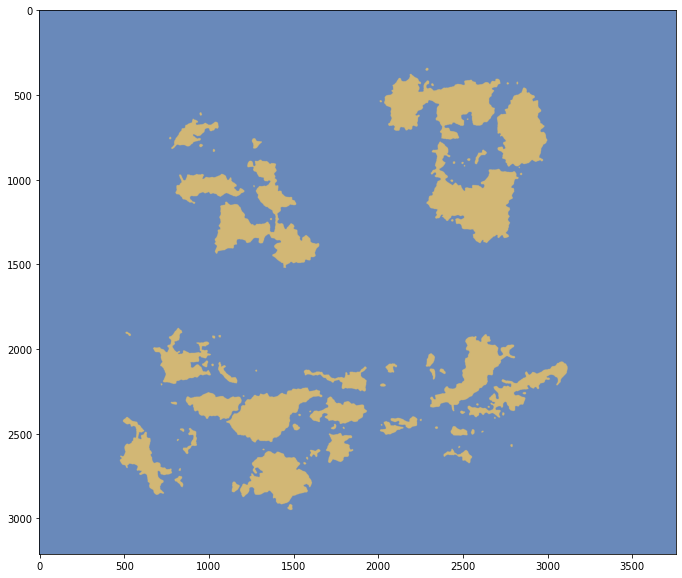

In [3]:
plt.rcParams["figure.figsize"] = (20,10)

# matplotlib interprets images in RGB format, but OpenCV uses BGR format
# so to convert the image so that it's properly loaded, convert it before loading
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # this converts it into RGB

plt.imshow(img_rgb)
plt.show()

## [PREPROCESSING 2] Binarize the image

For the reasons why it is necessary to binarize (and blur) images to find the center of shapes [see here](https://www.pyimagesearch.com/2016/02/01/opencv-center-of-contour/).

In [4]:
#from color to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#blur the borders
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

#checking the result
print('A sea pixel: ' + str(blurred[0,0]))
print('A land pixel: ' + str(blurred[1000,1000]))

A sea pixel: 133
A land pixel: 184


Note that we moved from RGB to grayscale, so for each pixel we expect a single number (and not the three color channels as before).

We are now ready to binarize the image. Any value between 133 and 184 could be used as threshold. 

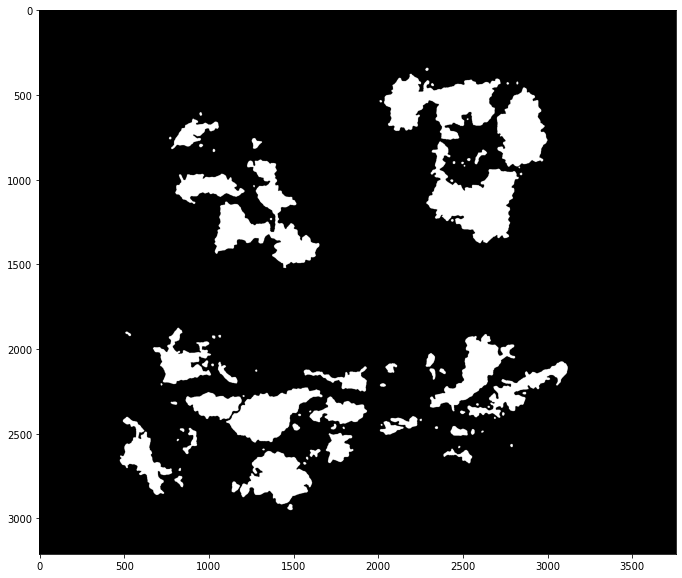

In [5]:
thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)[1]
plt.imshow(thresh, cmap = 'Greys_r') #using the built-in grey scale color map 
plt.show()

In [6]:
#checking the result
print('A sea pixel: ' + str(thresh[0,0]))
print('A land pixel: ' + str(thresh[1000,1000]))

A sea pixel: 0
A land pixel: 255


Notice that now the image is still grayscale (single channel), but the values are now at the extreme ranges of the available range. Sea pixels are set at zero (black) and land pixel are set at 255 (white).

## [PREPROCESSING 3] Find the center of each island

This is a two steps process. First we find the contour of each island. Then we compute the center of each contour.

In [7]:
# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#grabs the appropriate tuple value based on whether we are using OpenCV 2.4, 3, or 4. 
#You can read more about how the return signature of cv2.findContours
#changed between OpenCV versions at https://pyimagesearch.com/2015/08/10/checking-your-opencv-version-using-python/
cnts = imutils.grab_contours(cnts)

#printing the number of islands
print('We have found this many islands: ' + str(len(cnts)))

We have found this many islands: 86


It's now time to loop over each island contour and compute its center. The common formula used is, for each coordinate, to divide the first order moment by the zero order moment. For details see [here](https://www.pythonpool.com/opencv-moments/).

For extra clarity, we create a new image with the island borders in red and island centers marked by a black dot.

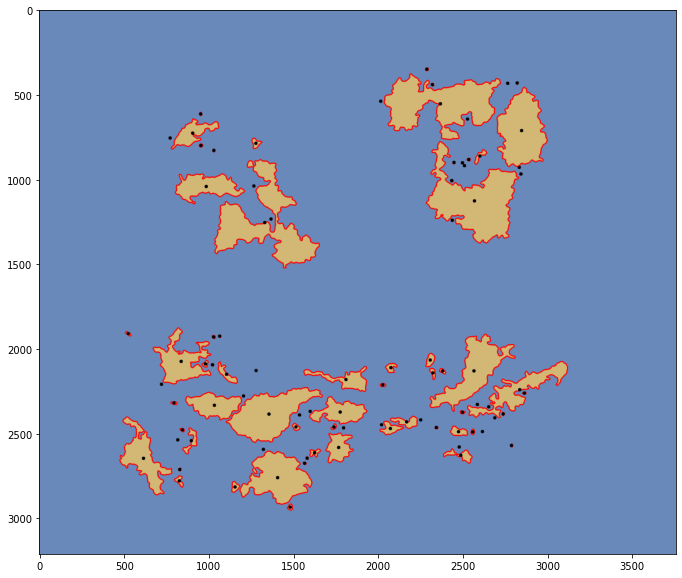

In [8]:
#room for centers of each island (we keep an x,y for each contour)
island_centers = np.empty(shape = (len(cnts), 2))
n = 0

#a new image, where we draw island borders and centers
annotated = img.copy()

# loop over the contours
for c in cnts:
    # compute the center of the contour
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    #keep track of what we found
    island_centers[n, :] = [cX, cY]
    n += 1
    
    # draw the contour and center of the shape on the image
    cv2.drawContours(annotated, [c], -1, (0, 0, 255), 5) #Syntax: cv2.drawcontours(source_image, contours, contours_ID, contour_color, contour_thickness)
    cv2.circle(annotated, (cX, cY), 10, (0, 0, 0), -1) #Syntax: cv2.circle(image, center_coordinates, radius, color, thickness)
    
#print the contoured image, after the usual RGB conversion
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
plt.imshow(annotated_rgb)
plt.show()

Zooming a bit:

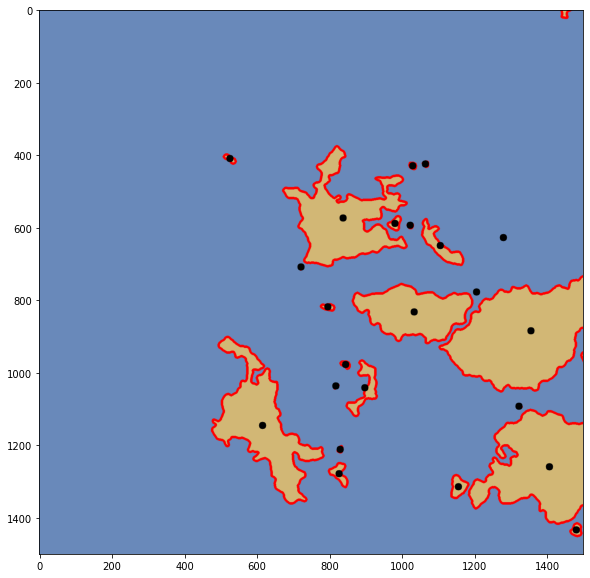

In [9]:
plt.imshow(annotated_rgb[1500:3000, 0:1500,:])
plt.show()    

Same area in the original image

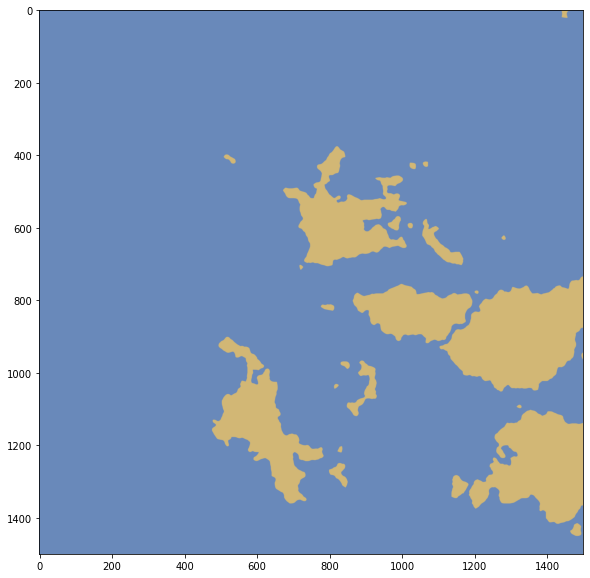

In [10]:
plt.imshow(img_rgb[1500:3000, 0:1500,:])
plt.show()  

Taking a look at the list of centers of each island: 

In [11]:
print('Shape of the matrix containing all the island centers:')
print(island_centers.shape)
print('Coordinates of the first four island centers:')
print(island_centers[0:4, :])

Shape of the matrix containing all the island centers:
(86, 2)
Coordinates of the first four island centers:
[[1481. 2933.]
 [1156. 2814.]
 [ 827. 2778.]
 [ 830. 2711.]]


# K means

It's now time to implement the algorithm proper. Let's refresh our memory, the steps are:

0. decide K, i.e. the number of clusters
1. randomly assign the centroids
2. each sample is assigned to the closest centroid
3. the centroids are updated, computing their new value as the average of all samples assigned to them
4. since the centroids moved, each sample is assigned again to the closest centroid
5. if during step 4 some sample was assigned to a different centroid, go to step 3. Otherwise the algorithm ends

## [K-means step 0] decide K

We'll start from the obvious choice. Once we have a decent implementation we can test different values, but for now:

In [12]:
k = 3

Since we are at it, let's create some room to store the centroids:

In [13]:
#we have as many centroids as clusters, and for each centroid
#we need to store x and y coordinates
centroids = np.zeros(shape = (k, 2))

#printing, just to check we are not making any mistakes
print(centroids)

[[0. 0.]
 [0. 0.]
 [0. 0.]]


## [K-means step 1a] randomly assign the centroids (naive approach)

The very simplest implementation of this step could go like this: "for each centroid, pick two random x and y values on the map. Those will be the coordinates of the centroid". It's easy to implement:

In [14]:
#instantiate a random generator
rng = default_rng()

#initialize and print the centroids
#documentation at https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.integers.html#numpy.random.Generator.integers
centroids[:, 0] = rng.integers(low = 0, high = img.shape[0], size = k)
centroids[:, 1] = rng.integers(low = 0, high = img.shape[1], size = k)
print(centroids)

[[2483. 1557.]
 [ 347. 2298.]
 [2033. 3089.]]


This method is easy to implement but contains a hidden problem, which becomes clear in step 2 of the algorithm. Imagine that instead of the numbers above you picked up the following random centroids:

<img src="archipelagos_two_colors_bad_centroids.png" alt="maps" style="width: 400px;"/>

The first centroid is somewhat unlucky, since it's so isolated that no islands will ever be assigned to it. In fact all islands are either closer to the second or to the third centroid. 

We could implement safeguards to compensate this scenario, e.g. repeating step one and two of the algorithm untill each centroids gets at least one island. Or we can be smarter in the way we pick the centroids.

## [K-means step 1b] randomly assign the centroids (picking islands)

In this implementation of Step 1 we randomly select three islands, which will be also used as centroids in the first iteration of the algorithm. In this way we ensure that each cluster gets assigned at least one island.

In [15]:
import random

#building a list containing consecutive values from zero to the number of islands (minus one)
l = []
l.extend(range(0, island_centers.shape[0]))

#picking k random islands (this is called sampling without repetition)
picked_islands = random.sample(l, k)

#use the coordinates of island centers to initialize the centroids
for i in range(k):
    centroids[i, 0] = island_centers[picked_islands[i], 0]
    centroids[i, 1] = island_centers[picked_islands[i], 1]
    
#printing, just to be sure
print(centroids)

[[2478. 2578.]
 [ 955.  799.]
 [2568. 1126.]]


## [K-means step 2] each sample is assigned to the closest centroid

"Closest" means with minimum distance. Since we are working with 2D maps the natural choice is to implement the [Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance).

In [16]:
#room for storing, for each island, the numeric id of the
#cluster to which the island is assigned
clusters = np.zeros(island_centers.shape[0])

#looping over each island
for i in range(island_centers.shape[0]):
    #we need to compute the distance between the current
    #island (i-th element) and each cluster centroid
    
    #room for storing the distances
    dist = np.zeros(k)
    
    #for each cluster
    for j in range(k):
        #for cleaner code, let's store the (x,y) coordinate of the 
        #current island and the current centroid in their own
        #dedicated variables
        x_island = island_centers[i, 0]
        y_island = island_centers[i, 1]
        x_centroid = centroids[j, 0]
        y_centroid = centroids[j, 1]
        
        #computing and storing euclidean distance
        dist[j] = np.sqrt((x_island - x_centroid) ** 2 + (y_island - y_centroid) ** 2)
    
    #find the minimum, and assign the number to the sample
    clusters[i] = np.argmin(dist)

Each island has been assigned to one cluster. Since we have K=3, the list `clusters` will contain indexes between zero and two:

In [17]:
print(clusters)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 2. 1. 1. 2. 1. 2. 2. 2. 2. 2. 1. 2. 2. 1.
 1. 2. 1. 1. 1. 2. 1. 2. 2. 2. 2. 2. 2. 2.]


## [Sidetrack] See the current clusters

It would be nice at this point to have some graphycal representation of what we are doing so far. Let's tweak the code we previously used to trace the island contours to show the cluster assignments and the centroids. First, let's define some colors in BGR convention:

In [18]:
COL = [
    (0, 0, 0), #BLACK
    (255, 255, 255), #WHITE
    (0, 0, 255) #RED
]

Then we trace the island contours using the cluster color, and plot the cluster centroids as big colored dots:

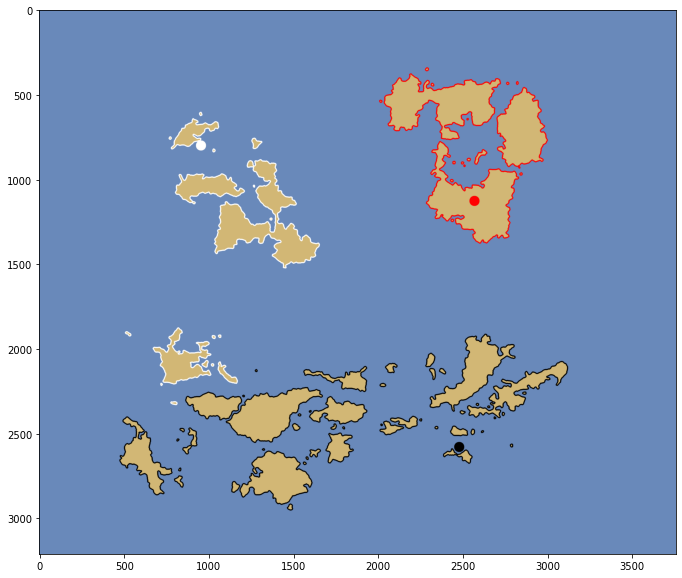

In [19]:
#a new image, where we draw island borders and centers
annotated = img.copy()

# loop over the contours
for i in range(len(clusters)):
    #the current contour
    c = cnts[i]
    
    #the corresponding color
    col = COL[clusters[i].astype(int)]
    
    # draw the contour
    cv2.drawContours(annotated, [c], -1, col, 5)

#loop over the centroids
for i in range(len(centroids)):
    x = centroids[i, 0].astype(int)
    y = centroids[i, 1].astype(int)
    col = COL[i]
    cv2.circle(annotated, (x, y), 30, col, -1) 

#print the annotated image
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB) # this converts it into RGB
plt.imshow(annotated_rgb)
plt.show()

That's way more clear. The island assignment seems to work: islands get the color of the closest centroid.

## [K-means step 3] update the centroids

Now that we have assigned each island to a cluster, we can update the centroids so that they actually represent the average coordinates of the cluster.

In [20]:
#print the centroids before the update
print('Before updating:')
print(centroids)

#loop over the centroids
for i in range(len(centroids)):
    #take notes of the coordinates of the island centers
    Xs = []
    Ys = []
    
    #loop over samples
    for j in range(len(clusters)):
        #if the island is not assigned to the current centroid we just skip it
        if clusters[j] != i:
            continue
        #if we get here the island belong to the current cluster,
        #let's take note of its coordinates
        Xs.append(island_centers[j, 0])
        Ys.append(island_centers[j, 1])
    
    #updating the centers to average values
    centroids[i, 0] = np.mean(Xs)
    centroids[i, 1] = np.mean(Ys)

print('After updating')
print(centroids)

Before updating:
[[2478. 2578.]
 [ 955.  799.]
 [2568. 1126.]]
After updating
[[1881.06122449 2442.71428571]
 [ 996.63157895 1461.26315789]
 [2535.88888889  768.        ]]


## Sidetrack: support functions

The code above was fine for a first implementation, but if we want to implement any kind of loop it will require to be compacted. In the following cells we implement a few custom functions that do exactly what we have done above. 

For these functions we'll use the convention to name all local version of global variables with the prefix "my_". So if a function requires to use the `centroids` variable, the local one will be `my_centroids`. This is not strictly required (we could even directly access global variables) but it's by far a good programming practice to have a good separation between local and global variable, and have functions never accessing global scope.

The function signatures will be:

* `random_centroids(my_island_centers, my_k)` for step one
* `update_samples(my_island_centers, my_centroids)` for step two
* `update_centroids(my_island_centers, my_clusters)` for step three

### A function for STEP 1

Nothing fancy, we just reproduce the code from above but packed into a function.

In [21]:
def random_centroids(my_island_centers, my_k):
    #room for results
    new_centroids = np.zeros(shape = (my_k, 2))
    
    #building a list containing consecutive values from zero to the number of islands (minus one)
    l = []
    l.extend(range(0, my_island_centers.shape[0]))

    #picking k random islands (this is called sampling without repetition)
    picked_islands = random.sample(l, my_k)

    #use the coordinates of island centers to initialize the centroids
    for i in range(my_k):
        new_centroids[i, 0] = my_island_centers[picked_islands[i], 0]
        new_centroids[i, 1] = my_island_centers[picked_islands[i], 1]

    #ænd we are done
    return(new_centroids)

### A function for STEP 2

Update the sample assignment. Each island is marked as belonging to the cluster with the closest centroid.


In [22]:
def update_samples(my_island_centers, my_centroids):
    #room for results
    new_clusters = np.zeros(my_island_centers.shape[0])
    
    #loop over islands (samples)
    for i in range(len(new_clusters)):
        dist = np.zeros(my_centroids.shape[0])
        #compute distances
        for j in range(len(dist)):
            x_island = my_island_centers[i, 0]
            y_island = my_island_centers[i, 1]
            x_centroid = my_centroids[j, 0]
            y_centroid = my_centroids[j, 1]
            #compute distance
            dist[j] = np.sqrt((x_island - x_centroid) ** 2 + (y_island - y_centroid) ** 2)

        #find and store the minimum
        new_clusters[i] = np.argmin(dist)
    
    #done
    return(new_clusters)

### A function for STEP 3

Cluster centroids are calculated as the average coordinates of all islands of a cluster.

In [23]:
def update_centroids(my_island_centers, my_clusters):
    #we can reconstrut k from the current arguments, so that
    #we don't need to add a third argument to the function
    my_k = (np.max(my_clusters) + 1).astype(int)
    
    #room for results
    new_centroids = np.zeros((my_k, 2))
    
    #loop over the centroids
    for i in range(my_k):
        #take notes of the coordinates of the island centers
        Xs = []
        Ys = []

        #loop over samples
        for j in range(len(my_island_centers)):
            #if the island is not assigned to the current centroid we just skip it
            if my_clusters[j] != i:
                continue
            #if we get here is a good sample
            Xs.append(my_island_centers[j, 0])
            Ys.append(my_island_centers[j, 1])

        #updating the centers to average values
        new_centroids[i, 0] = np.mean(Xs)
        new_centroids[i, 1] = np.mean(Ys)
    
    #done
    return(new_centroids)

### A function for plotting clusters

This function is not strictly necessary but it helps for checking the status of our implementation. Please note that it requires a set of colors to be used, which the user will need to hand pick. Other arguments are the island contours, the centroids, the assigned clusters, and the original image that serves as base.

In [24]:
def plot_map(my_img, my_clusters, my_cnts, my_centroids, my_COL):
    #a new image, where we draw island borders and centers
    annotated = my_img.copy()

    # loop over the contours
    for i in range(len(my_clusters)):
        #the current contour
        c = my_cnts[i]
        
        #the corresponding color
        col = my_COL[my_clusters[i].astype(int)]

        # draw the contour
        cv2.drawContours(annotated, [c], -1, col, 5)

    #loop over the centroids
    for i in range(len(my_centroids)):
        x = my_centroids[i, 0].astype(int)
        y = my_centroids[i, 1].astype(int)
        col = my_COL[i]
        cv2.circle(annotated, (x, y), 30, col, -1) 

    #print the contoured image
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB) # this converts it into RGB
    plt.imshow(annotated_rgb)
    plt.show()

## The full algorithm

It's now time to put all together. As a reminder, we inherit from the code above the following variables:

* `k` : the number of clusters
* `island_centers` : the coordinates of each island center
* `img` : the image as read form cv2 module (in BGR mode)
* `cnts` : list of contours of all islands, extracted using imutils module
* `COL` : hand picked list of colors to be used in the annotated maps


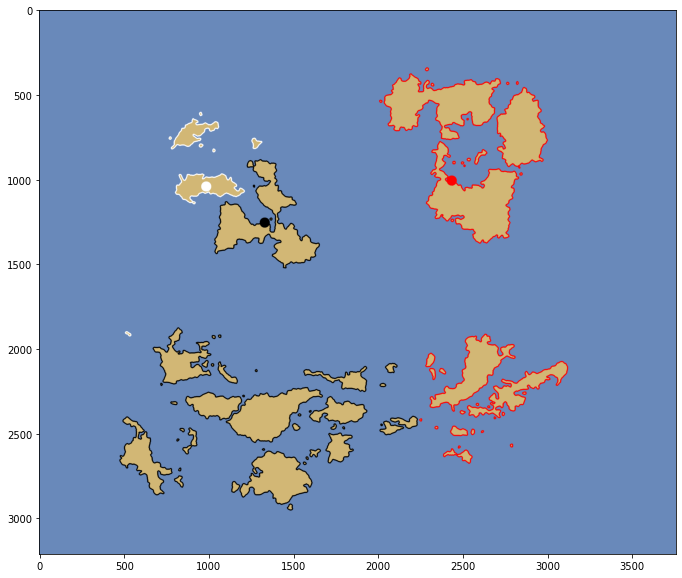

In [25]:
#step one: initialize centroids
centroids = random_centroids(island_centers, k)

#step two: assign islands to the closest centroid
clusters = update_samples(island_centers, centroids)

#plotting the situation so far
plot_map(img, clusters, cnts, centroids, COL)

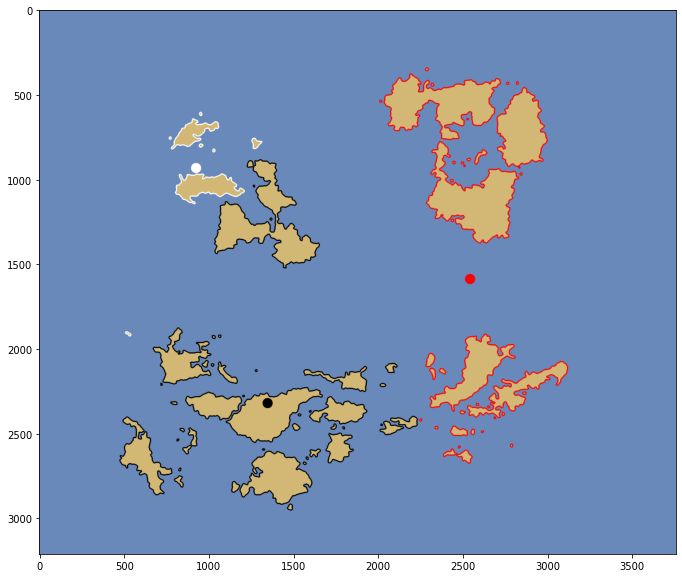

In [26]:
#step three: updating the centroids (and plotting again)
centroids = update_centroids(island_centers, clusters)
plot_map(img, clusters, cnts, centroids, COL)

We are now ready for STEP 4: updating the island assignments. This is functionally identical to step two, and in fact it's implemented using the same function.

In [27]:
#step four: updating again the cluster list
clusters2 = update_samples(island_centers, centroids)

The next step would be to compare the current assignment (stored in `clusters2`) to the previous one (stored in `clusters`). If they are the same the algorithm has reached the end. If not we need to go back to step three.

In [28]:
#check if there's any difference
diff = any(clusters != clusters2)

#printing what we found
print('Should we keep looping? ' + str(diff))

Should we keep looping? True


To be able to actually "go back to step 3" we need a loop construct. The full algorithm will thus look like the following:

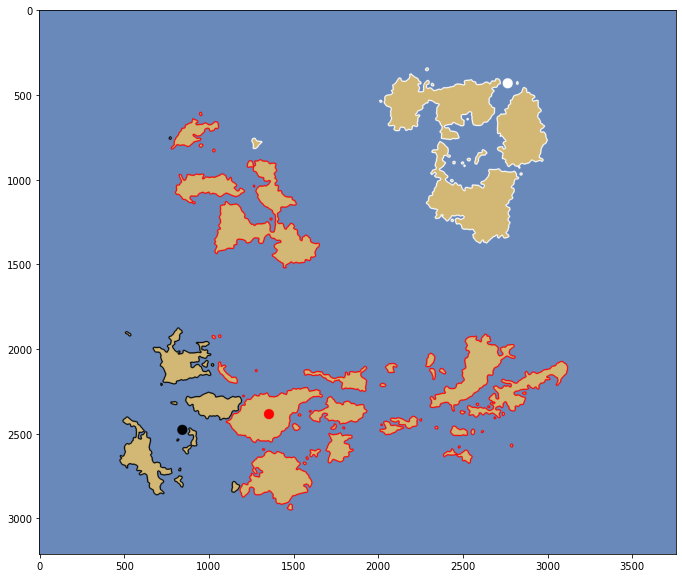

Changes
Changes
Changes
Changes
Changes


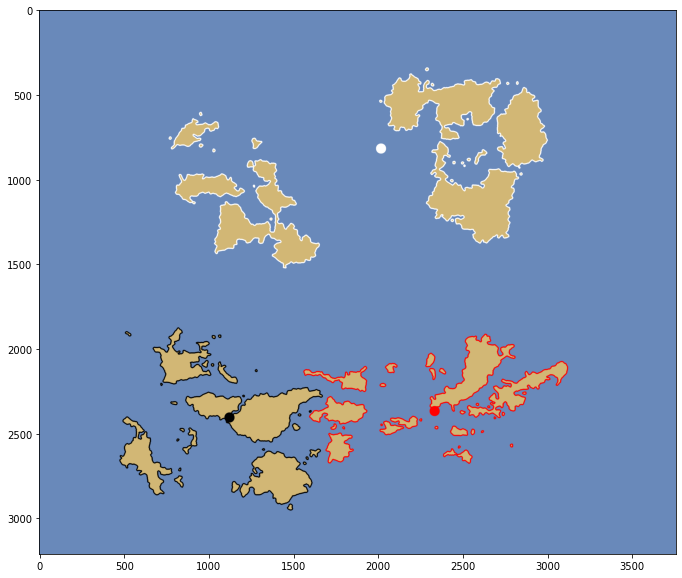

In [29]:
#this is a safeguard: we are going to do these many
#loops at maximum, so that if for some reason the 
#algorithm never converges we can still recover
#the execution without having to stop the kernel
nmax = 20

#step one: initialize centroids
centroids = random_centroids(island_centers, k)

#step two: assign islands to the closest centroid
clusters = update_samples(island_centers, centroids)

#plotting the situation so far
plot_map(img, clusters, cnts, centroids, COL)

#staring an infinite loop
while True:
    #step three: updating the centroids
    centroids = update_centroids(island_centers, clusters)
    
    #step four: updating again the cluster list
    clusters2 = update_samples(island_centers, centroids)
    
    #check if we need to keep looping
    if any(clusters != clusters2):
        #we found changes, so we print a small message
        #and overwrite the current cluster assignment
        print('Changes')
        clusters = clusters2
    else:
        #we found no changes, so we can stop the loop
        break
    
    #safeguard
    nmax -= 1
    if nmax == 0:
        print('Emergency break!')
        break

#plotting again the final result        
plot_map(img, clusters, cnts, centroids, COL)

After four iteration the algorithm ended. Notice that, contrary to  what one would expect, the two groups of northern islands ended up in the same cluster, while the southern archipelago was divided between red and black clusters. This is one of the possible result and is completely acceptable. It is also heavily dependent on the initial choice of random centroids.

## The full algorithm (in a function)

The natural extension of what we did so far is to implement the K-means algorithm in a function, so that with a single command we can rerun the whole procedure and explore a) the impact of the initial choice of centroids and b) the effect of changing the value of K.

Since we are at it, it's better to tweak the plot function so that we can do a side by side comparison.
We prepare two functions with the following signatures:

* `annotate_map(my_img, my_clusters, my_cnts, my_centroids, my_COL)` : given the original image and information on clusters, draws island borders and centroids with the proper colors on an image that is returned (not plotted, just returned)
* `kmeans(my_k, my_island_centers, my_img, my_cnts, my_COL)` : implements the whole K means algorithm

In [30]:
def annotate_map(my_img, my_clusters, my_cnts, my_centroids, my_COL):
    #a new image, where we draw island borders and centers
    annotated = my_img.copy()

    # loop over the contours
    for i in range(len(my_clusters)):
        #the current contour
        c = my_cnts[i]
        
        #the corresponding color
        col = my_COL[my_clusters[i].astype(int)]

        # draw the contour
        cv2.drawContours(annotated, [c], -1, col, 5)

    #loop over the centroids
    for i in range(len(my_centroids)):
        x = my_centroids[i, 0].astype(int)
        y = my_centroids[i, 1].astype(int)
        col = my_COL[i]
        cv2.circle(annotated, (x, y), 30, col, -1) 
    
    #we return the annotated map, already in RGB mode
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    return(annotated_rgb)
    
def kmeans(my_k, my_island_centers, my_img, my_cnts, my_COL):
    #safeguard
    nmax = 20

    #step one: initialize centroids
    centroids = random_centroids(my_island_centers, my_k)

    #step two: assign islands to the closest centroid
    clusters = update_samples(my_island_centers, centroids)

    #saving the map with the initial random choice of centroids
    initial_map = annotate_map(my_img, clusters, my_cnts, centroids, my_COL)

    while True:
        centroids = update_centroids(my_island_centers, clusters)
        clusters2 = update_samples(my_island_centers, centroids)

        if any(clusters != clusters2):
            print('changes!')
            clusters = clusters2
        else:
            break

        #safeguard
        nmax -= 1
        if nmax == 0:
            print('emergency break')
            break

    #saving the final map
    final_map = annotate_map(my_img, clusters, my_cnts, centroids, my_COL)
    
    #plotting both maps, side by side
    plt.subplot(1, 2, 1)
    plt.imshow(initial_map)
    plt.subplot(1, 2, 2)
    plt.imshow(final_map)
    plt.show()

We are now ready to run the algorithm a few times, taking notes of the effect of initial centroid selection. Keep an eye on the number of iterations!

## Effect of initial random centroids

changes!
changes!


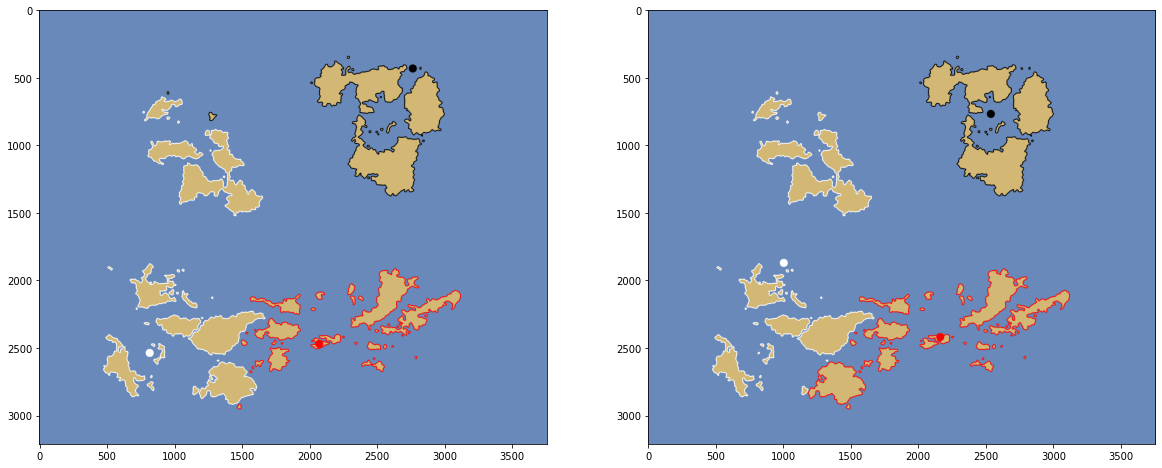

In [31]:
kmeans(k, island_centers, img, cnts, COL)

changes!
changes!


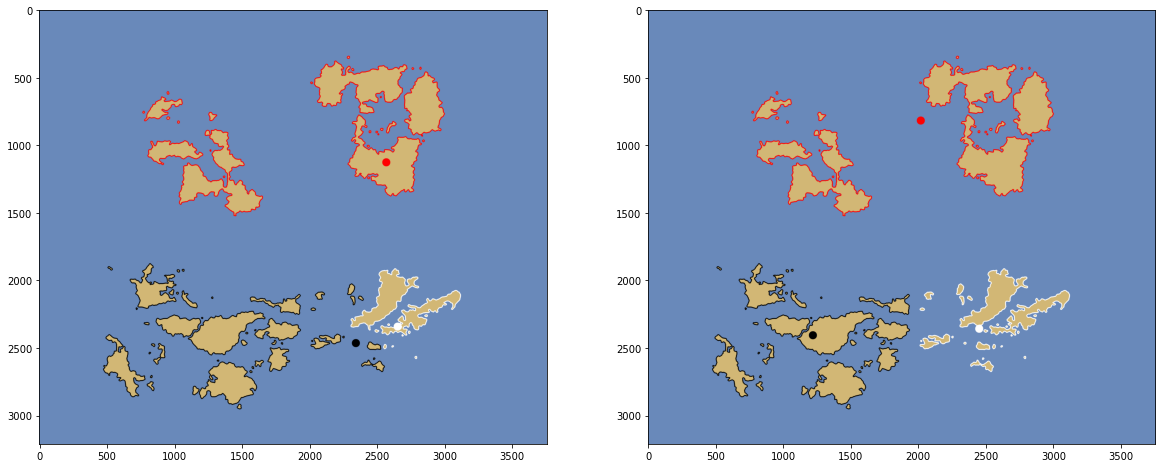

In [32]:
kmeans(k, island_centers, img, cnts, COL)

changes!
changes!
changes!
changes!
changes!
changes!
changes!
changes!
changes!


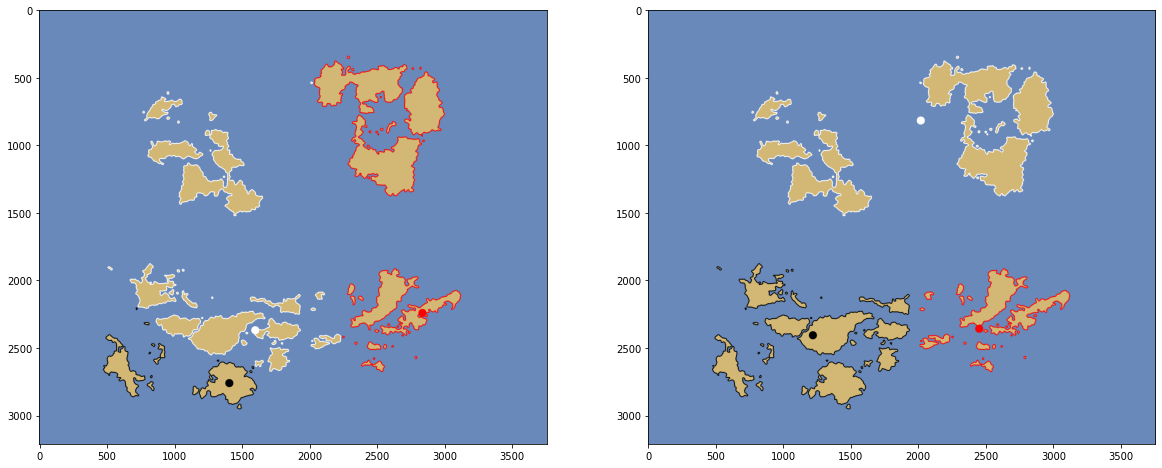

In [33]:
kmeans(k, island_centers, img, cnts, COL)

changes!
changes!
changes!


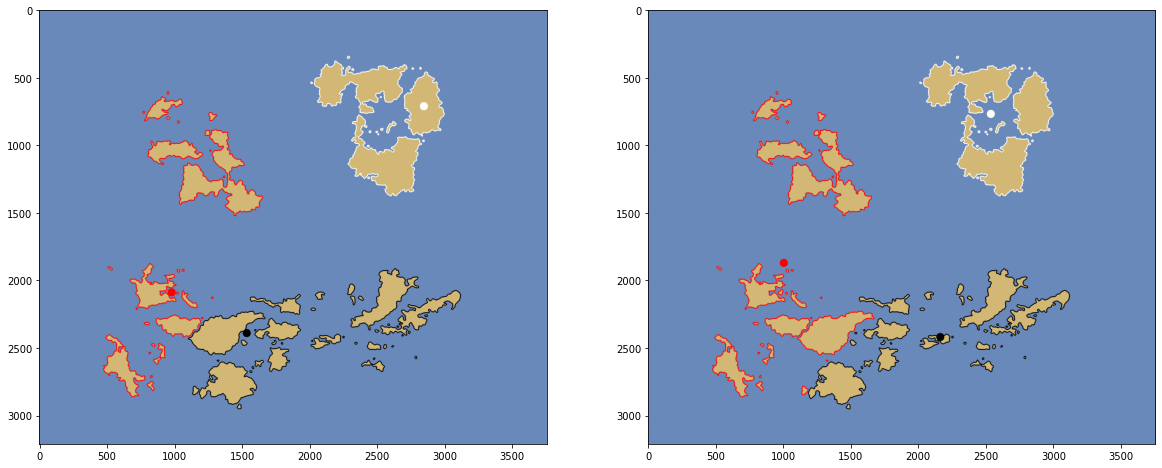

In [34]:
kmeans(k, island_centers, img, cnts, COL)

It appears that sourtern group of islands is aways split in two, and the rest of the islands are grouped depending on the initial random centroids.

Also the number of iterations varies a lot, from a minimim of three to a maximum of ten!

## Effect of choice of K

To be able to produce plots with a higher number of clusters we need to expand our palette. 

In [35]:
COL = [
    (0, 0, 0), #BLACK
    (255, 255, 255), #WHITE
    
    (0, 0, 255), #RED
    (0, 255, 0), #GREEN
    (255, 0, 0), #BLUE
    
    (255, 255, 0), #CYAN
    (255, 0, 255), #MAGENTA
    (0, 255, 255) #YELLOW
]

Let's use some caution and just increase K to four.

changes!
changes!
changes!


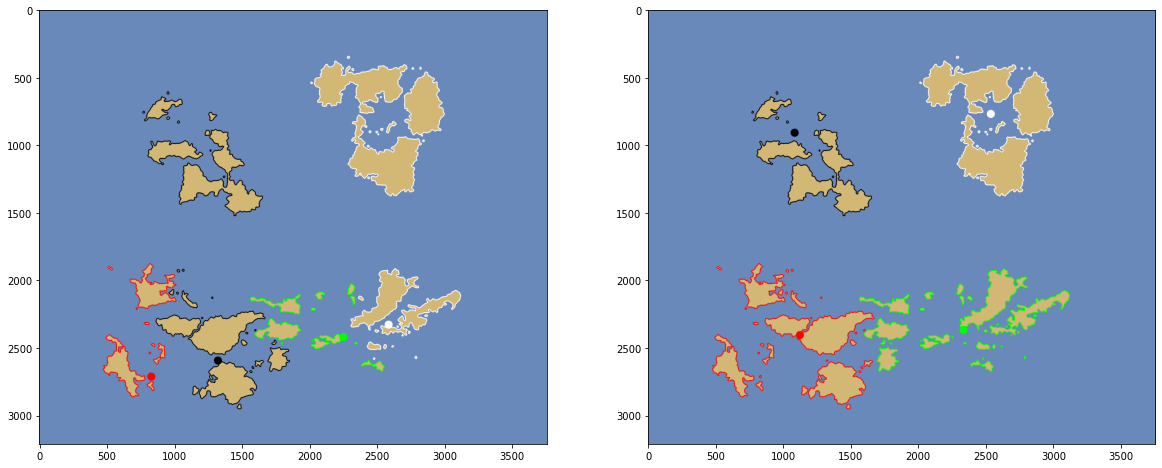

In [36]:
k = 4
kmeans(k, island_centers, img, cnts, COL)

Not surprisingly, even with very different initial pick of centroids, the fina result is sowewhat expected. The southern islands divided in two groups, and the northern island in other two.

Let's now dive in the deep end of the pool and try the maximum value of K allowed by our palette.

changes!
changes!
changes!


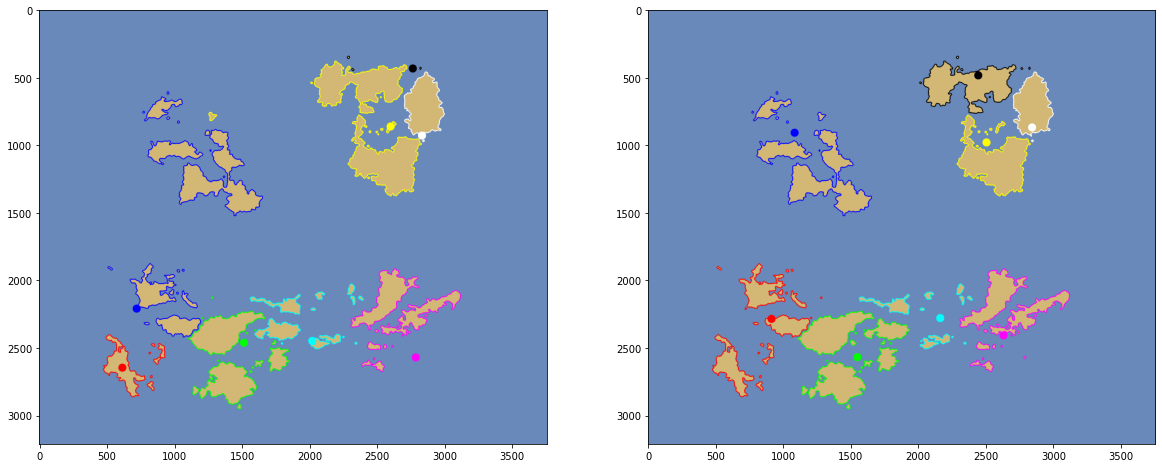

In [37]:
k = 8
kmeans(k, island_centers, img, cnts, COL)

Probably eight is a bit too much for our dataset, and we ended up having many fragmented groups. Notice a curious phenomenon: the cluster travel less. That's especillay true for those that start in a crowded area. Take a look at the north-east group of islands. The black, yellow and white centroids move very little. In fact the only centroid to have produced some significant update is the blue one, and only because the north-west islands were completely empty of centroids.

This pattern is not a fluke. Let's repeat the experiment a few times to verify it.

changes!
changes!
changes!
changes!
changes!
changes!
changes!


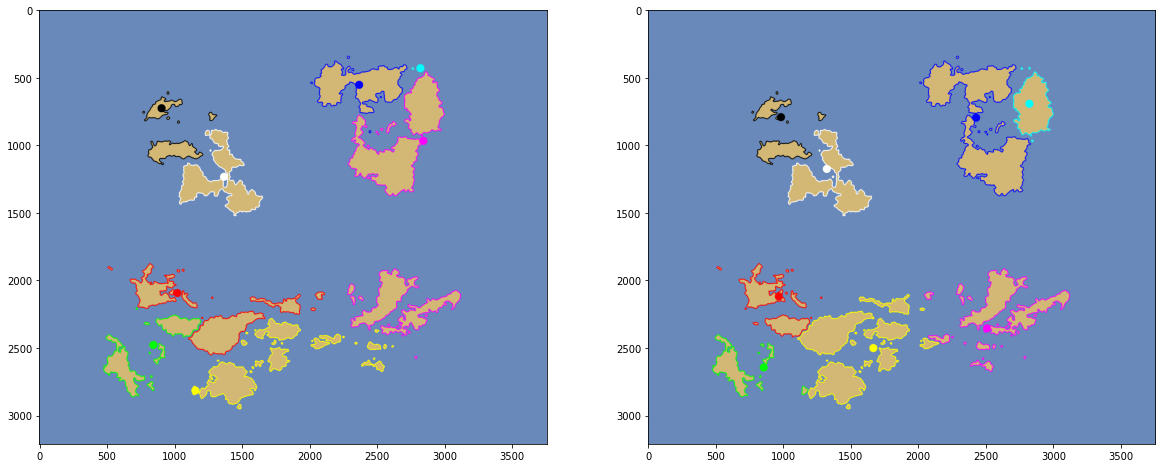

In [38]:
k = 8
kmeans(k, island_centers, img, cnts, COL)

changes!
changes!
changes!


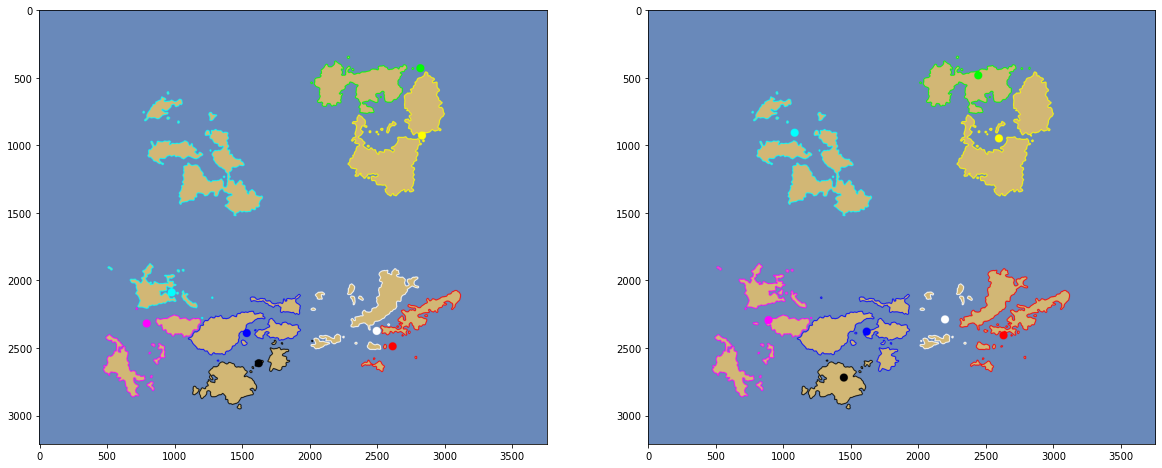

In [39]:
k = 8
kmeans(k, island_centers, img, cnts, COL)

The empty areas are quickly covered, but then nothing exciting happens. This is both a testament to the good convergence capability of K means and to its dependance on the initial pick.

# Conclusions

This ends the assignment. We implemented from scratch the very famous k-means clustering algorithms in its simplest version and explored some of its quirks. Obviously more sofisticated and efficient implementations are available in data-science oriented modules, e.g. [the scikit learn one](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) implements its own euristic for picking initial centroids and runs to algorithm several times, returning the best solution. However we think that building stuff from scratch, even in a simplified version, allows to reach a deeped understanding. We hope you enjoyed this article!